<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Creación y visualización de _embeddings_<a id="top"></a>

<i><small>Última actualización: 2024-03-12</small></i></div>

***

## Introducción

Los _embeddings_ son una técnica utilizada para representar datos de forma más compacta y significativa. En concreto, se utilizan para representar vectores de dimensiones muy grandes (por ejemplo, representaciones de palabras o imágenes) en espacios de mucha menor dimensión (normalmente unas pocas decenas o centenares de ellas).

Son muy útiles en aplicaciones de aprendizaje automático relacionadas con el procesamiento del lenguaje natural. Por ejemplo, pueden utilizarse para representar palabras en un espacio vectorial, de modo que las palabras que tienen un significado similar se representen cerca unas de otras. Esto es útil en tareas como la traducción automática, en la que se busca la palabra en la lengua de destino que tenga el significado más parecido a la palabra en la lengua de origen.

In [23]:
import torch

def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

dev = get_device()
print(f'Using device: {device}')

Using device: cuda


## Objetivos

En este cuaderno crearemos un Embedding y lo proyectaremos en un espacio bidimensional para probar cómo se pueden relacionar las palabras en un espacio vectorial en un contexto dado (problema).

Entrenaremos este embedding para una tarea de clasificación típicamente utilizada para empezar a aprender NLP, la de análisis de sentimiento de los comentarios de IMDb. Sin embargo, nos quedaremos en el punto en el que se entrena el _embedding_, dejando el análisis de sentimiento para más adelante.

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del cuaderno.

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [25]:
np.set_printoptions(precision=3)

plt.style.use('bmh')
plt.rcParams.update({'figure.figsize': (16, 9),'figure.dpi': 100})

***

## Obteniendo el conjunto de datos de [IMDb](https://www.imdb.com/)

Vamos a utilizar el dataset de IMDb como fuente de datos. Afortunadamente, lo tenemos en el módulo `datasets` de Keras, así que podemos cargarlo de la misma forma que hemos hecho con el dataset `mnist`.

In [26]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

Los comentarios descargados son en realidad índices de palabras. El diccionario `word->index` se obtiene con la función `get_word_index`. Obtendremos el diccionario y haremos el diccionario inverso para realizar la descodificación.

In [27]:
word_index = tf.keras.datasets.imdb.get_word_index()
index_word = {index: word for (word, index) in word_index.items()}

' '.join(index_word.get(i, '<UNK>') for i in x_train[0])

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but wh

No parece que tenga mucho sentido, ¿verdad? Esto es porque este diccionario es un poco tramposo, ya que no se corresponde exactamente con los datos del conjunto de datos:

- El primer índice de todos es 1, no 0. El 0 no se utiliza.
- Los índices están desplazados 3 enteros porque esos 3 primeros _tokens_ se reservan a palabras especiales (1 a principio de frase, 2 a elemento desconocido y 3 a no utilizado).

Por tanto, vamos a rellenar tres posiciones para ejecutar todos los índices y rellenar los valores por defecto. El 0 se utilizará para indicar un relleno (para rellenar las frases que no tienen la longitud fija requerida por los modelos). Por último, generaremos de nuevo el diccionario inverso

In [28]:
word_index = {word: (index + 3) for word, index in word_index.items()}
word_index['<PAD>'] = 0  # Padding
word_index['<SOS>'] = 1  # Start-of-sentence
word_index['<UNK>'] = 2  # Unknown
word_index['<UNU>'] = 3  # Unused

index_word = {index: word for (word, index) in word_index.items()}

' '.join(index_word.get(i, '<UNK>') for i in x_train[0])

"<SOS> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

Vale, esto ya es otra cosa. Ahora, vamos a por el primer problema de todos. Para obtener una entrada de longitud fija, podemos simplemente truncar las reseñas a un número fijo de palabras, digamos 64. Para las reseñas de más de 64 palabras, conservaremos sólo las primeras 64 palabras. En el caso de las opiniones de más de 64 palabras, sólo conservaremos las 64 primeras. Para las reseñas más cortas, rellenaremos los huecos de palabras no utilizadas con el valor que hayamos asignado al relleno (el 0). Con keras, esto es fácil de hacer usando la función `pad_sequences`:

In [31]:
def pad_sequences(sequences, maxlen, pad_value):
    padded_sequences = []
    for seq in sequences:
        seq = list(seq)  # cast a lista porque a veces puede fallar
        if len(seq) < maxlen:
            seq.extend([pad_value] * (maxlen - len(seq)))  # padding post
        else:
            seq = seq[:maxlen]  # truncar si se pasa de maxlen
        padded_sequences.append(seq)

    return torch.tensor(padded_sequences, dtype=torch.long)

pad_value = word_index['<PAD>']

x_train = pad_sequences(x_train, maxlen=64, pad_value=pad_value)
x_test = pad_sequences(x_test, maxlen=64, pad_value=pad_value)

print(f"Sequence: {', '.join(str(i) for i in x_train[0].tolist())}")
print(f"Comment:  {' '.join(index_word.get(i.item(), '<UNK>') for i in x_train[0])}")

Sequence: 1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469
Comment:  <SOS> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout


Vamos a convertir las entradas a tensores para poder procesarlas con `pytorch`

In [12]:
x_train_t = torch.tensor(x_train, dtype=torch.long, device=dev)
y_train_t = torch.tensor(y_train, dtype=torch.float32, device=dev)
x_test_t = torch.tensor(x_test, dtype=torch.long, device=dev)
y_test_t = torch.tensor(y_test, dtype=torch.float32, device=dev)

print(f'x_train_t shape: {x_train_t.shape}')
print(f'y_train_t shape: {y_train_t.shape}')

x_train_t shape: torch.Size([25000, 64])
y_train_t shape: torch.Size([25000])


## Usando la capa `Embedding`

Keras facilita **mucho** el trabajo con _Embeddings_ gracias a la capa `Embedding`, que puede entenderse como una capa de tipo `Dense` que mapea desde índices enteros (los índices de las palabras concretas) a vectores de palabras (sus correspondientes _embeddings_).

Los `Embeddings` se crean con dos parámetros; el primero (`input_dim`), el número de palabras, indica cuántas palabras tendrá en cuenta nuestro embedding. Todas aquellas que no se encuentren en dicho _embedding_ devolverán una representación para un token «desconocido». Cuanto mayor sea este parámetro, más palabras se podrán representar, pero más memoria ocupará y, sobre todo, más parámetros habrá que entrenar.

El segundo parámetro (`output_dim`) es la dimensión de los vectores resultantes. Este parámetro indica el número de características que se almacenarán para cada palabra del _embedding_. Este es el parámetro con el que más se juega cuando se crea una incrustación desde 0 para resolver un problema, del mismo modo que se experimenta con el número de neuronas de una capa `Dense`.

Por ejemplo, vamos a crear un _embedding_ con cualquier número de palabras y dimensión.

In [33]:
embedding_layer = nn.Embedding(
    num_embeddings=1000,  # items maximos para encodear
    embedding_dim=5       # numero de dimensiones que representan cada item
)

Cuando se crea una capa `Embedding`, sus pesos se inicializan aleatoriamente, como con cualquier otra capa. Y también como cualquier otra capa, dichos pesos se ajustarán gradualmente durante el entrenamiento.

Una vez entrenados, cabe esperar que los vectores de palabras aprendidos codifiquen aproximadamente las similitudes entre palabras, ya que, después de todo, se aprendieron para el problema específico sobre el que se entrena el modelo.

Si se pasa un número entero (es decir, el índice que representa una palabra) a una capa `Embedding`, ésta lo sustituye por su vector de palabras correspondiente:

In [34]:
indices = torch.tensor([1, 2, 4, 8], dtype=torch.long)
result = embedding_layer(indices)
print(result.detach().numpy())

[[ 0.085  1.613  0.332  0.731 -0.732]
 [-0.624 -1.646  1.541 -0.474 -0.533]
 [-0.155 -0.111 -1.     0.54  -0.587]
 [-0.914 -0.049 -1.702 -0.495 -1.808]]


Para problemas en los que tenemos un texto en lugar de una sola palabra, podemos pasar directamente un tensor 2D, de la forma `(num_sequences, sequence_length)`. El tensor devuelto tendrá la misma forma, pero con una dimensión más que serán las dimensiones de las palabras.

Por ejemplo, en el caso de pasarle una entrada bidimensional con la forma `(2, 4)` (es decir, 2 secuencias de 4 elementos cada una), el tensor devuelto tendrá un eje más con la dimensión que hayamos declarado en el _Embedding_:

In [35]:
indices = torch.tensor([
    [0, 1, 2, 3],
    [4, 5, 6, 7]
], dtype=torch.long)

result = embedding_layer(indices)
print(f'Result (shape = {result.shape}):\n{result.detach().numpy()}')

Result (shape = torch.Size([2, 4, 5])):
[[[ 1.101  1.016  1.272 -0.959 -0.867]
  [ 0.085  1.613  0.332  0.731 -0.732]
  [-0.624 -1.646  1.541 -0.474 -0.533]
  [-0.119 -0.146  0.931  0.597 -0.725]]

 [[-0.155 -0.111 -1.     0.54  -0.587]
  [ 0.35  -1.618 -1.474  0.651  0.373]
  [ 1.221  2.182 -1.477  1.263  0.786]
  [-1.037  0.676  0.459  0.391 -0.283]]]


Podemos ver que si damos un _batch_ de secuencias como entrada, un _Embedding_ devuelve un tensor 3D de tipo `float`, de la forma `(num_sequences, items_per_sequence, embedding_dim)`.

## Entrenamiento del modelo de clasificación

Vamos a crear un `TensorDataset` para cargarlo por medio de un `DataLoader` al modelo durante el entrenamiento

In [36]:
dataset_train = TensorDataset(x_train_t, y_train_t)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

Utilizaremos un modelo secuencial formado por el `Embedding` y una capa densa. Este modelo se entrenará para intentar dar respuesta a qué comentarios son negativos y cuáles positivos.

Entre todos los pesos que se entrenen, estarán los del `Embedding`. Una vez finalizado el entrenamiento, nuestro `Embedding` tendrá una comprensión de las relaciones que existen entre nuestras palabras, al menos dentro de nuestro contexto de películas.

El modelo que crearemos será una primera capa `Embedding` (con una dimensión de rasgo de 2 para que podamos mostrar en una gráfica la localización espacial de las palabras) y una capa de salida de tipo sigmoidal que determina si es una buena crítica o no. El resto de capas intermedias a tu gusto.

In [39]:
WORDS_IN_VOCAB = len(word_index)
EMBEDDING_DIM  = 2
HIDDEN_DIM = 32

In [37]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return self.sigmoid(x)

In [40]:
model = LSTMModel(WORDS_IN_VOCAB, EMBEDDING_DIM, HIDDEN_DIM).to(dev)
print(model)

LSTMModel(
  (embedding): Embedding(88588, 2)
  (lstm): LSTM(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Y ahora entrenamos el modelo.

In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  # binary crossentropy, para los del fondo

epochs = 5
history = {'loss': [], 'accuracy': []}

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader_train:
        x_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = model(x_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # accuracy
        predicted = (y_pred >= 0.5).float()  # redondeamos output
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    avg_loss = total_loss / len(dataloader_train)
    accuracy = correct / total  # binary accuracy

    history['loss'].append(avg_loss)
    history['accuracy'].append(accuracy)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1, Loss: 0.4631, Accuracy: 0.7818
Epoch 2, Loss: 0.4318, Accuracy: 0.7989
Epoch 3, Loss: 0.4037, Accuracy: 0.8165
Epoch 4, Loss: 0.3769, Accuracy: 0.8314
Epoch 5, Loss: 0.3544, Accuracy: 0.8433


Veamos la evolución del entrenamiento para comprobar que el modelo está aprendiendo.

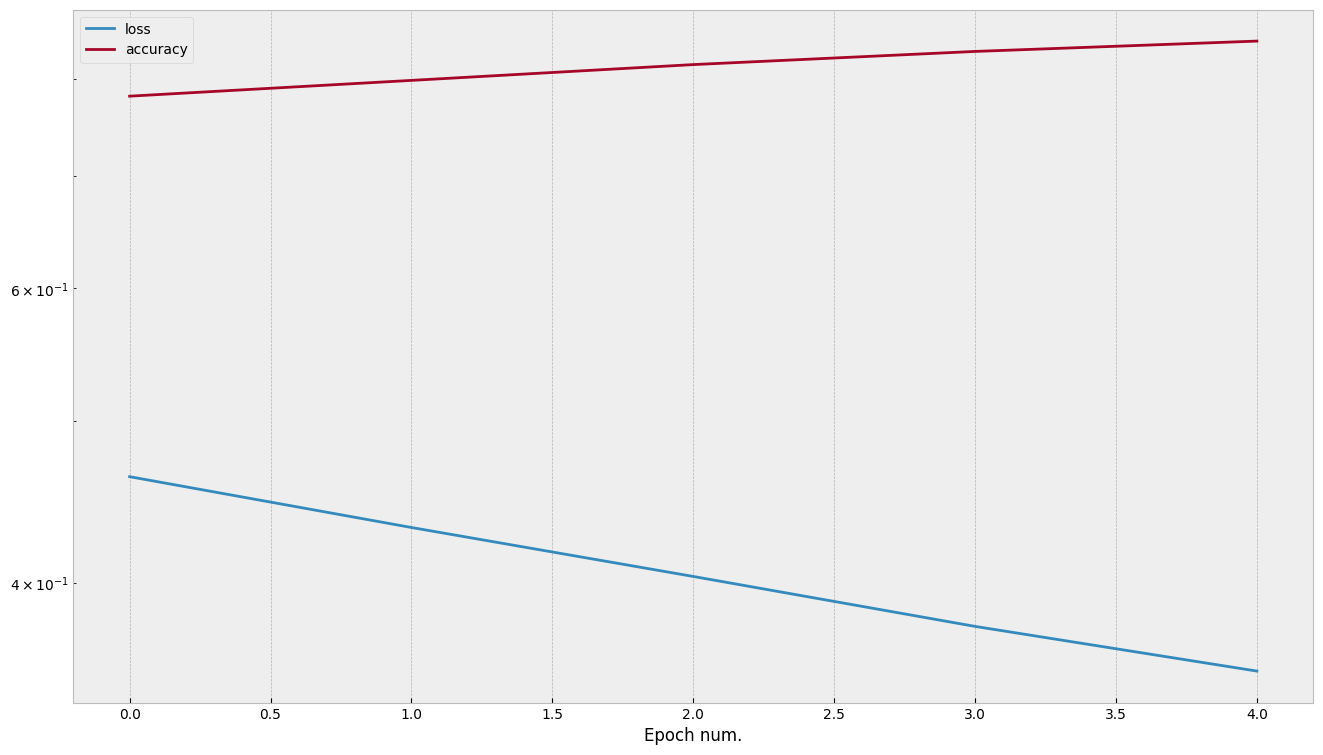

In [43]:
pd.DataFrame(history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

## Visualización del embedding

Para ver representado el `Embedding`, vamos a crear primero una función que nos dará la salida de nuestra capa de incrustación para una entrada dada.

In [ ]:
model = model.to(dev)



In [ ]:
f_embedding_out = tf.keras.backend.function(
    inputs=[model.layers[0].input],
    outputs=[model.layers[0].output],
)

Utilizaremos esta función para obtener la distribución de los vectores de palabras del conjunto de prueba.

In [56]:
input_tensor = torch.tensor(x_test[0]).unsqueeze(0).to(device)

# forward pass para conseguir la salida de la capam de embedding
embedding_layer = model.embedding     # la capa en cuestion
embedding_out = embedding_layer(input_tensor)

print(f'Input shape:  {x_test[0].shape}')
print(f'Output shape: {embedding_out.shape}')

Input shape:  torch.Size([64])
Output shape: torch.Size([1, 64, 2])


/tmp/ipykernel_606/541572569.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(x_test[0]).unsqueeze(0).to(device)


Podemos observar que, dada una secuencia, la salida `output` es una lista de un único tensor con la secuencia de salida

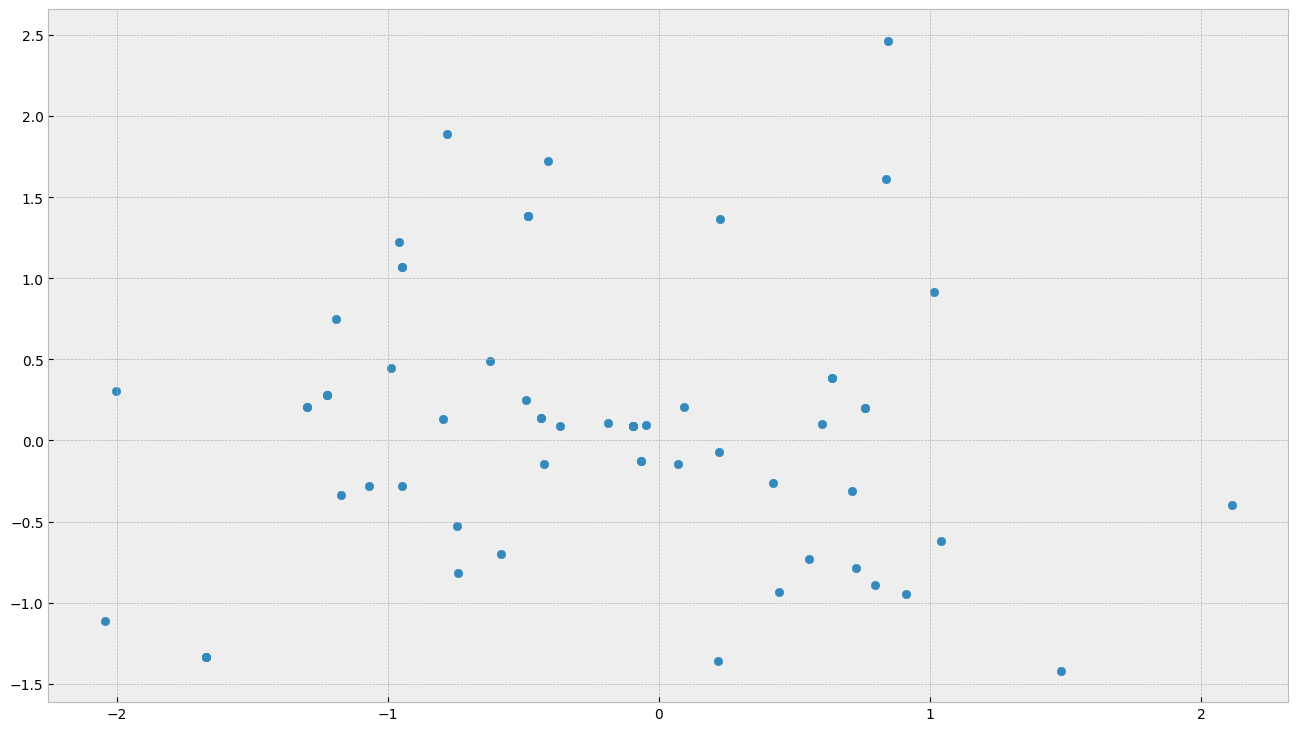

In [57]:
# sacamos embeddings de la reseña (similar a output[0] en TensorFlow)
sentence_words = embedding_out.squeeze(0).cpu().detach().numpy()

# y podemos mostrar los embeddings
plt.scatter(sentence_words[:, 0], sentence_words[:, 1])
plt.show()

Echemos un ojo a los vectores de los pesos asociados a determinadas palabras

In [60]:
weights = embedding_layer.weight.cpu().detach().numpy()
df = pd.DataFrame(weights, index=index_word.values())

df.loc[['cage', 'horrible', 'seagal', 'pascal'], :].head()

,0,1
cage,-1.328349,1.190852
horrible,1.276910,0.503314
seagal,-1.891829,-1.092151
pascal,-0.911686,-1.699226


Vamos a probar una cosa. Crearemos una reseña ficticia y veremos cómo se distribuyen las palabras en el espacio bidimensional que hemos creado.

In [62]:
review = ['cage', 'reeves', 'seagal', 'cavill', 'good', 'matrix', 'bad', 'crap', 'affleck']
encoded_review = torch.tensor([word_index.get(w, word_index['<UNK>']) for w in review]).to(device)

encoded_review

tensor([1935, 5983, 3272,    2,   52, 2661,   78,  595, 6475], device='cuda:0')

Ahora veamos la salida de `Embedding` si le damos a revisar:

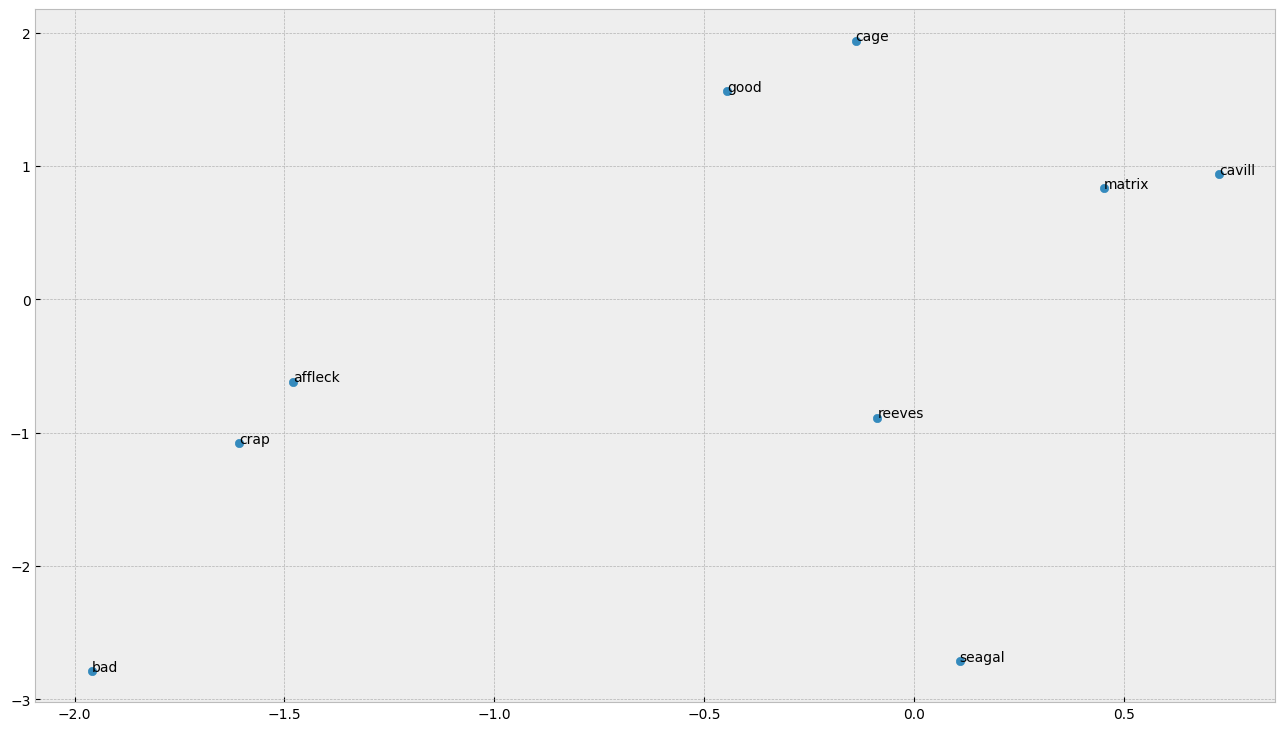

In [64]:
v_words = embedding_layer(encoded_review).cpu().detach().numpy()

plt.scatter(v_words[:, 0], v_words[:, 1])
for i, word in enumerate(review):
    plt.text(v_words[i, 0], v_words[i, 1], word)
plt.show()

In [65]:
maxlen = 64
encoded_review_padded = torch.nn.functional.pad(encoded_review, (0, maxlen - len(encoded_review)), value=word_index['<PAD>'])


model.eval()
with torch.no_grad():
    output = model(encoded_review_padded.unsqueeze(0))  # batch dimension
    print(output)

tensor([[0.2905]], device='cuda:0')


Vemos que, en principio, nuestro `embedding` ha localizado espacialmente las palabras que están más relacionadas. De este modo, podemos identificar qué actores están más cerca de qué calificadores en función de su proximidad a ellos

# Conclusiones

Hemos creado una incrustación a partir de ciertos datos y demostrado cómo puede crear una representación en un espacio vectorial de las palabras incluidas en ella. Esta representación permite agrupar en el espacio vectorial palabras que tienen significados similares, lo que puede ser útil para tareas de análisis de textos como la clasificación de documentos o la búsqueda de información. También hemos mostrado cómo la incrustación puede utilizarse para realizar tareas como la identificación de palabras desconocidas y la detección de palabras mal escritas.

En general, el uso de incrustaciones para representar datos de texto es una técnica valiosa en el aprendizaje automático y el procesamiento del lenguaje natural. Permiten representar las palabras de forma más significativa en un espacio vectorial, lo que facilita la identificación de patrones y la realización de tareas de clasificación y predicción. Además, su capacidad para agrupar palabras similares en un espacio vectorial puede mejorar significativamente la precisión y la eficacia de los modelos de análisis de texto.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>